# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up graphlab create

In [58]:
import graphlab
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [59]:
sales = graphlab.SFrame('kc_house_data.gl/')

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [60]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [61]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [62]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000002  | 0.512829     | 6962915.603493     | 426631.749026 |

| 2         | 3        | 0.000002  | 0.556499     | 6843144.200219     | 392488.929838 |

| 3         | 4        | 0.000002  | 0.601692     | 6831900.032123     | 385340.166783 |

| 4         | 5        | 0.000002  | 0.646960     | 6847166.848958     | 384842.383767 |

| 5         | 6        | 0.000002  | 0.689469     | 6869667.895833     | 385998.458623 |

| 6         | 7        | 0.000002  | 0.734492     | 6847177.773672     | 380824.455891 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Find what features had non-zero weight.

In [63]:
model_all["coefficients"].print_rows(num_rows=18)

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None |  274873.05595 |  None  |
|     bedrooms     |  None |      0.0      |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|    bathrooms     |  None | 8468.53108691 |  None  |
|   sqft_living    |  None | 24.4207209824 |  None  |
| sqft_living_sqrt |  None | 350.060553386 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
|    waterfront    |  None |      0.0      |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None |      0.0      |  None  |
|      grade       |  None | 842.068034898 |  None  |
|    sqft_above    |  None | 20.0247224171 |  None  |
|  sqft_basement   |  None |

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [64]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

[(10.0, 625766285142461.2), (31.622776601683793, 625766285362395.2), (100.0, 625766286057887.0), (316.22776601683796, 625766288257224.9), (1000.0, 625766295212186.0), (3162.2776601683795, 625766317206077.8), (10000.0, 625766386760661.5), (31622.776601683792, 625766606749281.4), (100000.0, 625767302791633.4), (316227.76601683791, 625769507643885.1), (1000000.0, 625776517727025.8), (3162277.6601683795, 625799062845466.9), (10000000.0, 625883719085424.5)]


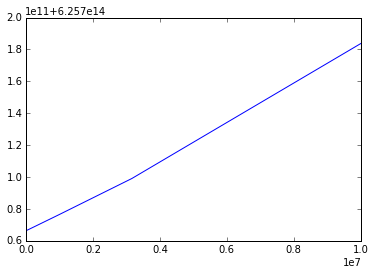

In [66]:
rsses = []
plot_x = []
plot_y = []
for i in np.logspace(1, 7, num=13):
    model = graphlab.linear_regression.create(training, target='price', features=all_features, verbose=False,
                                              validation_set=None, l2_penalty=0, l1_penalty=i)
    predictions = model.predict(validation)
    rss = sum((validation["price"]-predictions)**2)
    rsses.append((i,rss))
    plot_x.append(i)
    plot_y.append(rss)
print rsses
plt.plot(plot_x,plot_y)

*** QUIZ QUESTIONS ***
1. What was the best value for the `l1_penalty`?
2. What is the RSS on TEST data of the model with the best `l1_penalty`?

In [73]:
best_l1=min(rsses, key = lambda t: t[1])
print best_l1

model = graphlab.linear_regression.create(training, target='price', features=all_features, verbose=False,
                                              validation_set=None, l2_penalty=0, l1_penalty=best_l1[0])
predictions = model.predict(testing)
rss = sum((testing["price"]-predictions)**2)
print rss/1e6

(10.0, 625766285142461.2)
156983602.382


***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [69]:
model=graphlab.linear_regression.create(validation, target='price', features=all_features, verbose=False,
                                              validation_set=None, l2_penalty=0, l1_penalty=best_l1[0])
model["coefficients"].print_rows(num_rows=18)

+------------------+-------+------------------+--------+
|       name       | index |      value       | stderr |
+------------------+-------+------------------+--------+
|   (intercept)    |  None |   21251.456037   |  None  |
|     bedrooms     |  None |  8023.23712748   |  None  |
| bedrooms_square  |  None |  2315.12367247   |  None  |
|    bathrooms     |  None |   23478.596342   |  None  |
|   sqft_living    |  None |  35.8035138152   |  None  |
| sqft_living_sqrt |  None |  1081.33507648   |  None  |
|     sqft_lot     |  None | -0.0262827717894 |  None  |
|  sqft_lot_sqrt   |  None |  145.436647604   |  None  |
|      floors      |  None |   20447.520062   |  None  |
|  floors_square   |  None |   11514.116277   |  None  |
|    waterfront    |  None |  595536.451305   |  None  |
|       view       |  None |  95362.3454158   |  None  |
|    condition     |  None |  7063.68121335   |  None  |
|      grade       |  None |   6191.241929    |  None  |
|    sqft_above    |  None |  3

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [67]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [68]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [78]:
nonzeroes=[]
for l1_penalty in l1_penalty_values:
    model = graphlab.linear_regression.create(training, target='price', features=all_features, verbose=False,
                                              validation_set=None, l2_penalty=0, l1_penalty=l1_penalty)
    nonzeroes.append((l1_penalty,model['coefficients']['value'].nnz()))
print nonzeroes

[(100000000.0, 18), (127427498.57031322, 18), (162377673.91887242, 18), (206913808.11147901, 18), (263665089.87303555, 17), (335981828.62837881, 17), (428133239.8719396, 17), (545559478.11685145, 17), (695192796.17755914, 17), (885866790.41008317, 16), (1128837891.6846883, 15), (1438449888.2876658, 15), (1832980710.8324375, 13), (2335721469.0901213, 12), (2976351441.6313133, 10), (3792690190.7322536, 6), (4832930238.5717525, 5), (6158482110.6602545, 3), (7847599703.5146227, 1), (10000000000.0, 1)]


Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzero` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzero` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [79]:
l1_penalty_min = 2976351441.6313133
l1_penalty_max = 3792690190.7322536

***QUIZ QUESTIONS***

What values did you find for `l1_penalty_min` and`l1_penalty_max`? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [80]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzero`.

In [88]:
penalties=[]
for l1_penalty in np.linspace(l1_penalty_min,l1_penalty_max,20):
    model = graphlab.linear_regression.create(training, target='price', features=all_features, verbose=False,
                                              validation_set=None, l2_penalty=0, l1_penalty=l1_penalty)
    nonzero = model['coefficients']['value'].nnz()
    if nonzero == max_nonzeros:
        predictions = model.predict(validation)
        rss = sum((validation["price"]-predictions)**2)
        penalties.append((l1_penalty,rss,nonzero))
print penalties

[(3448968612.1634369, 1046937488751713.6, 7), (3491933809.484539, 1051147625612863.0, 7), (3534899006.8056412, 1055992735342999.2, 7), (3577864204.1267428, 1060799531763290.2, 7)]


***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [90]:
best_l1 = min(penalties, key = lambda t: t[1])
print best_l1

(3448968612.1634369, 1046937488751713.6, 7)


In [94]:
model = graphlab.linear_regression.create(training, target='price', features=all_features, verbose=False,
                                              validation_set=None, l2_penalty=0, l1_penalty=best_l1[0])
model['coefficients'].print_rows(num_rows=18)

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None | 222253.192544 |  None  |
|     bedrooms     |  None | 661.722717782 |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|    bathrooms     |  None | 15873.9572593 |  None  |
|   sqft_living    |  None | 32.4102214513 |  None  |
| sqft_living_sqrt |  None | 690.114773313 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
|    waterfront    |  None |      0.0      |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None |      0.0      |  None  |
|      grade       |  None | 2899.42026975 |  None  |
|    sqft_above    |  None | 30.0115753022 |  None  |
|  sqft_basement   |  None |